In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.metrics import roc_auc_score
from geopy.distance import vincenty
sns.set_style("darkgrid")

In [47]:
%%javascript
$('.nbp-app-bar').toggle()

<IPython.core.display.Javascript object>

# Read and Split the Data

In [3]:
weather=pd.read_csv('weather2.csv')
readings=pd.read_csv('readings.csv')

In [4]:
chicago=pd.merge(readings, weather, on='Date').drop(['Date', 'Month', 'Year', 'CULEX'], axis=1);
print(chicago.shape)
chicago.head()

(10506, 12)


,Virus,DayRunner,ALTER,PIPIENS,PIPIENS-RESTUANS,RESTUANS,near_hotspot,near_chompspot,avg_rain1,avg_rain2,avg_dry1,avg_dry2
0,0,149,0,0,1,0,1,4,0.714286,0.428571,0.857143,0.571429
1,0,149,0,0,0,1,1,4,0.714286,0.428571,0.857143,0.571429
2,0,149,0,0,0,1,0,3,0.714286,0.428571,0.857143,0.571429
3,0,149,0,0,1,0,2,4,0.714286,0.428571,0.857143,0.571429
4,0,149,0,0,0,1,2,4,0.714286,0.428571,0.857143,0.571429


In [5]:
# Split the data
X = chicago.drop(['Virus'], axis=1)
y = chicago['Virus']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state=42)
X_train.shape # Notice the number of rows in the training set. This should stay constant.

(8404, 11)

In [6]:
# List the features
X.columns

Index(['DayRunner', 'ALTER', 'PIPIENS', 'PIPIENS-RESTUANS', 'RESTUANS',
       'near_hotspot', 'near_chompspot', 'avg_rain1', 'avg_rain2', 'avg_dry1',
       'avg_dry2'],
      dtype='object')

# Model 1. KNN classifier 

#### fit on the training, predict on the testing data

In [7]:
# train the model
neighs = KNeighborsClassifier(n_neighbors=7)
knn_model = neighs.fit(X_train, y_train)

In [8]:
# The crossvalidiation score scores our performance on the training data. 
scores = cross_val_score(knn_model, X_train, y_train, cv=5)
np.mean(scores), np.std(scores) # This is the mean of the 5 cv scores, plus its standard dev.

(0.9439549088809569, 0.0046952383870515566)

In [9]:
# Predict the y values on the testing data.
y_hat = knn_model.predict(X_test)
y_hat_probs = knn_model.predict_proba(X_test)[:,1]

#### Uhhh, what does that mean?

In [10]:
# Let's take a look at our predictions:
checkitout=pd.DataFrame(y_hat, columns=['Pred_Probability'])
print(checkitout.shape)
print(len(y_test)) # confirmed: they are the same length!

(2102, 1)
2102


In [11]:
# Do those predictions usually match the actual values?
comparison=pd.DataFrame(list(zip(y_test,y_hat)), columns=['Actual','Prediction'])
comparison.head()
# Hmm, the first five don't look very good.

,Actual,Prediction
0,0,0
1,0,0
2,1,0
3,0,0
4,0,0


In [12]:
# Well, is there any difference in the MEAN prediction for the two classes?
print(comparison[comparison['Actual']==0]['Prediction'].mean())
print(comparison[comparison['Actual']==1]['Prediction'].mean())
import scipy.stats as stats
print(stats.ttest_ind(comparison[comparison['Actual']==0]['Prediction'], comparison[comparison['Actual']==1]['Prediction']))
# Yes there is a sig diff!! We're more likely to predict "positive" on readings that are ACTUALLY positive. yay!
# So, that's really promising. Let's move to scoring.

0.0035140562248995983
0.03636363636363636
Ttest_indResult(statistic=-4.6703664446109654, pvalue=3.1968007254014293e-06)


#### Score my model

In [13]:
# Set up some empty lists, so we can compare our models at the end
acc=[]
sens=[]
spec=[]
roc=[]

In [14]:
# There are two different ways to get the accuracy score, which is our primary metric:
y_hat = knn_model.predict(X_test)
modscore=100*(knn_model.score(X_test, y_test))
accuracy=100*metrics.accuracy_score(y_test, y_hat)
acc.append(accuracy)
print(modscore)
print(accuracy)

94.6241674596
94.6241674596


In [15]:
# A confusion matrix tells us our false positives and false negatives:
mat = confusion_matrix(y_test, y_hat)
print (mat)

[[1985    7]
 [ 106    4]]


In [16]:
# Let's interpret that.
tn, fp, fn, tp = mat.ravel()
sensitivity = 100*tp/(tp+fn)
specificity=100*tn/(tn+fp)
sens.append(sensitivity)
spec.append(specificity)

print('sensitivity:', sensitivity)
print('specificity:', specificity)

sensitivity: 3.63636363636
specificity: 99.6485943775


#### ROC-AUC score

In [17]:
# Our ROC-AUC score measures the trade-off between specificity and sensitivity
roc_score=100*roc_auc_score(y_test, y_hat_probs)
roc.append(roc_score)
print(roc_score)

71.4028842643


# Model 2. Logistic Classifier

#### fit on the training, predict on the testing data

In [18]:
# train the model
logit = LogisticRegression()
log_model=logit.fit(X_train, y_train)

In [19]:
# The crossvalidiation score scores our performance on the training data. 
scores = cross_val_score(logit, X_train, y_train, cv=5)
np.mean(scores), np.std(scores) # This is the mean of the 5 cv scores, plus its standard dev.

(0.9474060149977056, 0.00028727056066025418)

In [20]:
# Predict the y values on the testing data.
y_hat = log_model.predict(X_test)
y_hat_probs = log_model.predict_proba(X_test)[:,1]

In [21]:
# Check out the coefficients
coefficients = pd.concat([pd.DataFrame(X_train.columns),pd.DataFrame(np.transpose(log_model.coef_))], axis = 1)
coefficients

,0,0
0,DayRunner,0.006868
1,ALTER,-1.951962
2,PIPIENS,0.340164
3,PIPIENS-RESTUANS,-0.161630
4,RESTUANS,-1.261480
5,near_hotspot,0.414786
6,near_chompspot,0.073452
7,avg_rain1,-0.212584
8,avg_rain2,-1.182181
9,avg_dry1,-1.003647


#### Score my model

In [22]:
# There are two different ways to get the accuracy score, which is our primary metric:
modscore=100*(log_model.score(X_test, y_test))
accuracy=100*metrics.accuracy_score(y_test, y_hat)
acc.append(accuracy)
print(modscore)
print(accuracy)

94.7668886775
94.7668886775


In [23]:
# A confusion matrix tells us our false positives and false negatives:
mat = confusion_matrix(y_test, y_hat)
print (mat)

[[1992    0]
 [ 110    0]]


In [24]:
# Let's interpret that.
tn, fp, fn, tp = mat.ravel()
sensitivity = 100*tp/(tp+fn)
specificity=100*tn/(tn+fp)
sens.append(sensitivity)
spec.append(specificity)

print('sensitivity:', sensitivity)
print('specificity:', specificity)

sensitivity: 0.0
specificity: 100.0


#### ROC-AUC score

In [25]:
# Our ROC-AUC score measures the trade-off between specificity and sensitivity
roc_score=100*roc_auc_score(y_test, y_hat_probs)
roc.append(roc_score)
print(roc_score)

70.5394304491


# Model 3. Random Forest Classifier

#### Instantiate and Fit the Model with Default settings

In [26]:
rf = RandomForestClassifier()
tree_model=rf.fit(X_train, y_train)

#### Grid search to determine the best parameters

In [27]:
from sklearn.model_selection import GridSearchCV

In [28]:
# How many features do we have?
X_train.shape

(8404, 11)

In [29]:
param_grid = {
        'n_estimators': [100, 150], 
        'max_depth': [3, 4, None],
        'min_samples_split': [5, 10, 15, 100],
        'min_samples_leaf': [5, 10],
#         'max_features': [10, 20, 25, 30], # This is not meaningful because I only have a few predictors
        'class_weight': [None]    
        }

In [30]:
grid = GridSearchCV(tree_model, param_grid=param_grid, n_jobs = 1, cv=3)
grid.fit(X_train, y_train);
# We should re-run the RF model with these optimal parameters:
print(grid.best_params_)

{'class_weight': None, 'max_depth': None, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 100}


Note: Using `gridsearch` improved my ROC-AUC score by 3 points over the default settings! But it also completely re-arranged the importance of my features, with "day of year" becoming the most important, and my (carefully engineered) location and weather features dropping a lot.

#### Instantiate and Fit the Model with optimized settings

In [31]:
rf = RandomForestClassifier(class_weight= None, 
                            max_depth= 3, 
                            min_samples_leaf= 5, 
                            min_samples_split= 5, 
                            n_estimators= 100)
tree_model=rf.fit(X_train, y_train)

In [32]:
# The crossvalidiation score scores our performance on the training data. It's quite high (but we have imbalance)
scores = cross_val_score(tree_model, X_train, y_train, cv=5)
np.mean(scores), np.std(scores) # This is the mean of the 5 cv scores, plus its standard dev.

(0.94752506261675329, 0.0002195732545577469)

In [33]:
# Predict the y values on the testing data.
y_hat = tree_model.predict(X_test)
y_hat_probs = tree_model.predict_proba(X_test)[:,1]

#### Score the model

In [34]:
# ACCURACY
accuracy=100*metrics.accuracy_score(y_test, y_hat)
acc.append(accuracy)
print(accuracy)

94.7668886775


In [35]:
# A confusion matrix tells us our false positives and false negatives:
mat = confusion_matrix(y_test, y_hat)
print (mat)

[[1992    0]
 [ 110    0]]


In [36]:
# Let's interpret that.
tn, fp, fn, tp = mat.ravel()
sensitivity = 100*tp/(tp+fn)
specificity=100*tn/(tn+fp)
sens.append(sensitivity)
spec.append(specificity)

print('sensitivity:', sensitivity)
print('specificity:', specificity)

sensitivity: 0.0
specificity: 100.0


#### ROC-AUC score

In [37]:
# Our ROC-AUC score measures the trade-off between specificity and sensitivity
roc_score=100*roc_auc_score(y_test, y_hat_probs)
roc.append(roc_score)
print(roc_score)

77.7571650237


### Random Forest Feature Importances

In [38]:
# compute the feature importances
importances = tree_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in tree_model.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

Feature ranking:
1. feature 0 (0.400612)
2. feature 10 (0.131404)
3. feature 9 (0.094649)
4. feature 2 (0.092611)
5. feature 5 (0.087633)
6. feature 4 (0.062544)
7. feature 6 (0.054425)
8. feature 7 (0.039857)
9. feature 8 (0.021961)
10. feature 3 (0.013056)
11. feature 1 (0.001247)


In [39]:
len(importances)

11

In [40]:
feat_imp=pd.DataFrame(importances, index=X_test.columns, columns=['importance'])
feat_imp['importance'].sort_values(ascending=False).head(15)

DayRunner           0.400612
avg_dry2            0.131404
avg_dry1            0.094649
PIPIENS             0.092611
near_hotspot        0.087633
RESTUANS            0.062544
near_chompspot      0.054425
avg_rain1           0.039857
avg_rain2           0.021961
PIPIENS-RESTUANS    0.013056
ALTER               0.001247
Name: importance, dtype: float64

In [41]:
top15=pd.DataFrame(feat_imp['importance'].sort_values(ascending=False))

Text(0,0.5,'Feature Importance')

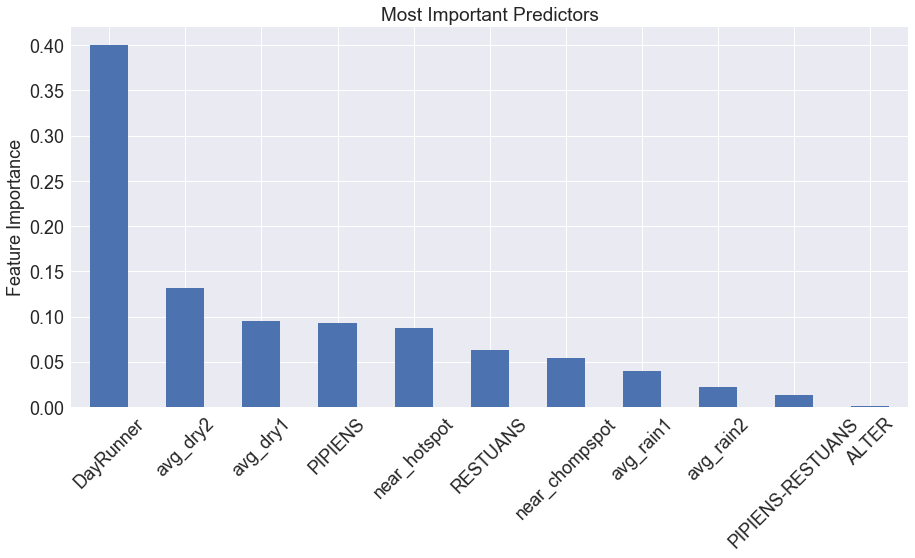

In [42]:
sns.set(style="darkgrid", color_codes=None)
# sns.palplot(sns.color_palette("RdBu", n_colors=7))
ax = top15.plot(kind='bar', legend=False, fontsize=18,  figsize=(15, 7))
plt.xticks(rotation = 45,  fontsize=18)
plt.title('Most Important Predictors',  fontsize=19)
plt.yticks(rotation = 0,  fontsize=18)
plt.ylabel('Feature Importance', rotation=90,  fontsize=18) 

# Compare Models

In [43]:
# Recap those scores for me, please.
models=['KNN', 'Logistic', 'Random Forest']
cols=['Model', 'Accuracy', 'Sensitivity', 'Specificity', 'ROC-AUC']
print(acc)
print(sens)
print(spec)
print(roc)

[94.624167459562329, 94.766888677450041, 94.766888677450041]
[3.6363636363636362, 0.0, 0.0]
[99.648594377510037, 100.0, 100.0]
[71.402884264330041, 70.539430449069002, 77.757165023731289]


In [44]:
# Show me that in a table:
model_scores=pd.DataFrame(list(map(list, zip(models, acc, sens, spec, roc))), columns=cols)
model_scores

,Model,Accuracy,Sensitivity,Specificity,ROC-AUC
0,KNN,94.624167,3.636364,99.648594,71.402884
1,Logistic,94.766889,0.000000,100.000000,70.539430
2,Random Forest,94.766889,0.000000,100.000000,77.757165


Text(0,0.5,'Score')

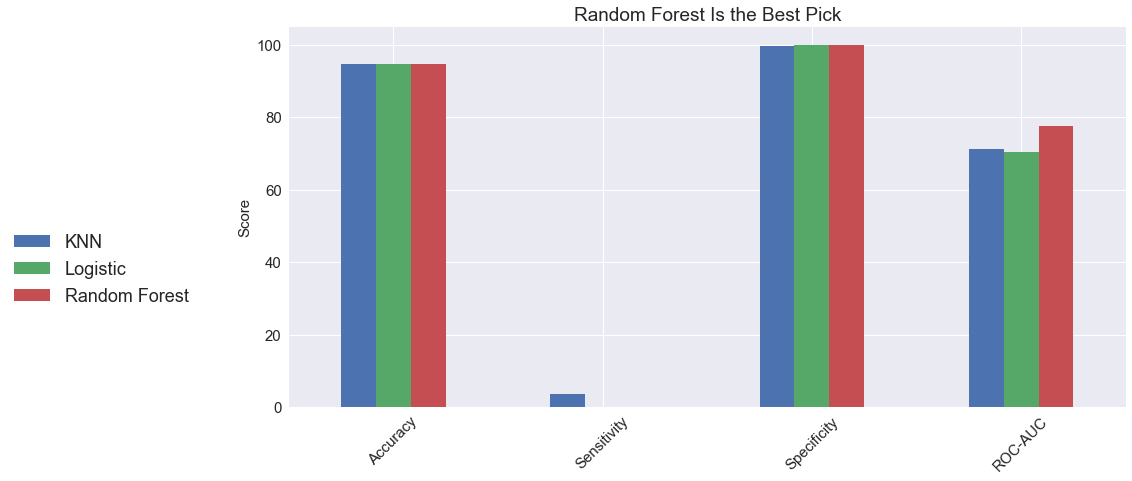

In [45]:
# Make it pretty. 
ax = model_scores.set_index('Model').T.plot(kind='bar', legend=False, fontsize=12, figsize=(15, 7))
ax.legend(loc=1, fontsize=18, bbox_to_anchor=(-0.1, 0.5))
plt.xticks(rotation = 45,  fontsize=15)
plt.title('Random Forest Is the Best Pick',  fontsize=19)
plt.yticks(rotation = 0,  fontsize=15)
plt.ylabel('Score', rotation=90,  fontsize=15)  

## Let's draw the ROC-AUC curve for the Random Forest Model.

In [48]:
from sklearn.metrics import roc_curve, auc

In [55]:
# Empty dictionaries.
FPR = dict()
TPR = dict()
ROC_AUC = dict()
# For class 1 (has WNV), find the area under the curve:
FPR[1], TPR[1], _ = roc_curve(y_test, y_hat_probs)
ROC_AUC[1] = auc(FPR[1], TPR[1])

In [59]:
# What is that ROC-AUC score?
ROC_AUC[1]

0.77757165023731289

In [61]:
# Same but using the scikit default:
roc_auc_score(y_test, y_hat_probs)

0.77757165023731289

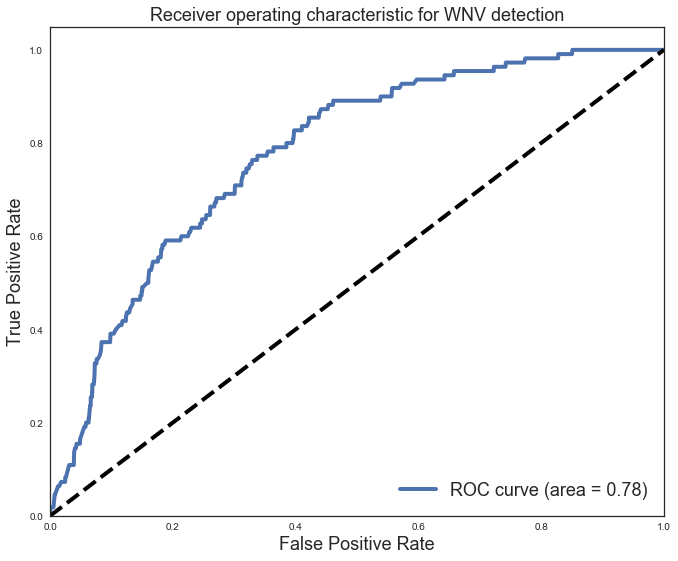

In [63]:
# Let's draw that:
plt.style.use('seaborn-white')
plt.figure(figsize=[11,9])
plt.plot(FPR[1], TPR[1], label='ROC curve (area = %0.2f)' % ROC_AUC[1], linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic for WNV detection', fontsize=18)
plt.legend(loc="lower right", fontsize=18);

# Pickle this RF model so we can score the Kaggle Submission.

In [65]:
import pickle
with open('tree_model.pickle', 'wb') as f:
    pickle.dump(tree_model, f, protocol=0)